# Chapter 7. Machine Learning Assisted Dynamical Classification of Trans-Neptunian Objects

Additional material to chapter *7: Machine Learning Assisted Dynamical Classification of
Trans-Neptunian Objects* in eds. Valerio Carruba, Evgeny Smirnov, Dagmara Anna Oszkiewicz, *Machine Learning for Small Bodies in the Solar System*, Elsevier 2024.

Authors of chapter 7 are:
*Kathryn Volk<sup>1</sup> and Renu Malhotra<sup>2</sup>*

<sup>1</sup>Planetary Science Institute, Tucson, AZ, USA<br>
<sup>2</sup>The University of Arizona, Tucson, AZ, USA<br>

Kathryn Volk is responsible for the following material.<br>

Note that the machine learning classifier for this example notebook is self-contained in this repository, but the example application of the classifier to a new TNO integration relies on tools from the in-development Small Body Dynamics Tool repository: https://github.com/small-body-dynamics/SBDynT<br>
Future improvements to the classifier will be made available in that repository, but we the classifier as described in the chapter is provided in frozen form here.

We need the following Python packages to read in the training/testing dataset and create the classifier

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

We will first read in the training/testing data. Most of the data columns are the data features described in Table 7.2 (the suffix '_short' indicating they are calculated from the 0.5 Myr integration, otherwise calculated from the 10 Myr integration). The columns not described in that table are:<br>
* r_o_a: whether the listed particle is based on a real TNO ('r') or an artificial one added to the training set ('a')<br>
* G08_class: the Gladman et al 2008 classification labels for that particle ('scattering', 'detached', 'classical', 'Nresonant')<br>
    * mio: the 'main', 'inner', or 'outer' indicator for classical objects (not used)
    * p, q, m, n: the integers associated with the reosnant argument (equation 7.2, not used)
* simplified_G08: the simplified version of the Gladman et al scheme that combines classical and detached into class-det ('scattering', 'class-det', 'Nresonant')<br>
* split_res: the labeling scheme with 'class-det', 'res' (eccentricity-type resonant), 'mixed-res' (mixed-e-i-resonant) and 'scattering' <br>
* split_clas_det: the labeling scheme with 'scattering', 'res' (all resonant particles), 'nonres' (completely non-resonant class-det particles), and 'res-interacting' (clas-det particles that intermittently librate in resonance for short periods)<br>


In [2]:
training_file = 'chapter_7_TNO_training_data.csv'
all_TNOs = pd.read_csv(training_file, skipinitialspace=True, index_col=False, low_memory=False)
all_TNOs

,r_o_a,particle,G08_class,mio,p,q,m,n,a_mean,a_sigma,...,delta_aminmax_to_mean_density_ratio_normed_short,delta_amin_to_amax_density_ratio_short,delta_amin_to_amax_density_ratio_normed_short,eminmax_to_mean_density_ratio_short,emin_to_emax_density_ratio_short,iminmax_to_mean_density_ratio_short,imin_to_imax_density_ratio_short,simplified_G08,split_res,split_class_det
0,r,15760-1,classical,m,0,0,0,0,43.92890,0.004729,...,0.334434,0.159915,0.182707,1.231600,0.945353,1.263729,1.418102,class-det,class-det,nonres
1,r,15760-2,classical,m,0,0,0,0,43.91913,0.004740,...,0.365185,0.250351,0.293961,1.223818,0.941465,1.267544,1.421076,class-det,class-det,nonres
2,r,15760-3,classical,m,0,0,0,0,43.93865,0.004808,...,0.391765,0.277100,0.319085,1.241550,0.936051,1.273215,1.419956,class-det,class-det,nonres
3,r,15807-1,classical,m,0,0,0,0,43.75184,0.008008,...,0.508250,0.164776,0.180407,1.035771,1.130292,1.358424,1.032121,class-det,class-det,nonres
4,r,15807-2,classical,m,0,0,0,0,43.73971,0.009469,...,0.596586,0.260224,0.270464,1.013033,1.118959,1.351390,1.036196,class-det,class-det,nonres
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15222,a,sc1157-2,scattering,0,0,0,0,0,197.95630,5.032031,...,4.545040,1175.785000,662.990000,0.738471,1.245917,1.351579,1.249550,scattering,scattering,scattering
15223,a,sc1158-2,scattering,0,0,0,0,0,234.68030,24.473510,...,7.743352,943.000000,919.540500,0.884053,0.969697,0.637814,2.064327,scattering,scattering,scattering
15224,a,sc1164-1,scattering,0,0,0,0,0,50.40452,1.172324,...,0.482239,0.427335,0.435698,0.751617,0.965767,1.611263,1.012978,scattering,scattering,scattering
15225,a,sc1166-2,scattering,0,0,0,0,0,176.30930,8.280939,...,8.428187,1190.000000,1242.741000,0.840195,0.908082,1.003684,1.664436,scattering,scattering,scattering


We will train and test the classifier based on the simplified Gladman et al 2008 classifications (which we found to be the most accurate in our chapter)</br>
Any of the other label columns above can be used instead

In [3]:
clasfeat = 'simplified_G08'
sG08_types = list( set(all_TNOs[clasfeat]) )
sG08_dict = { sG08_types[i] : i for i in range( len(sG08_types) ) }
int_sG08_dict = { i : sG08_types[i] for i in range( len(sG08_types) ) }
sG08_classes = all_TNOs[clasfeat].map(sG08_dict)
print("integer and class correspondence: ",int_sG08_dict)


rs=283
features_train, features_test, classes_train, classes_test = train_test_split(
    all_TNOs, sG08_classes, test_size=0.333, random_state=rs)
print("training set length: ",len(classes_train))
print("testing set length: ", len(classes_test))


ids_train = features_train['particle'].to_numpy()
ids_test = features_test['particle'].to_numpy()

#we have to drop the columns that aren't data features: 
drop_columns = ['r_o_a','particle','G08_class','mio','p','q','m','n','simplified_G08','split_res','split_class_det']

features_test.drop(drop_columns, axis=1, inplace=True)
features_test = features_test.to_numpy()
features_train.drop(drop_columns, axis=1, inplace=True)
features_train = features_train.to_numpy()

rs = 42
sG08_clf = GradientBoostingClassifier(max_leaf_nodes = None, 
                                 min_impurity_decrease=0.0, 
                                 min_weight_fraction_leaf = 0.0, 
                                 min_samples_leaf = 1, 
                                 min_samples_split=3, 
                                 criterion = 'friedman_mse',
                                 subsample = 0.9, 
                                 learning_rate=0.15, 
                                 max_depth=8, 
                                 max_features='log2', 
                                 n_estimators=300, 
                                 validation_fraction=0.1,
                                 random_state=rs)

sG08_clf.fit(features_train, classes_train)

integer and class correspondence:  {0: 'class-det', 1: 'scattering', 2: 'Nresonant'}
training set length:  10156
testing set length:  5071


GradientBoostingClassifier(learning_rate=0.15, max_depth=8, max_features='log2',
                           min_samples_split=3, n_estimators=300,
                           random_state=42, subsample=0.9)

Test the classifier

In [4]:
classes_predict = sG08_clf.predict(features_test)
score = accuracy_score(classes_test, classes_predict)
print("accuracy score: ", score)

accuracy score:  0.9755472293433248


To run a new object through the classifier, you will need to download the in-development Small Body Dynamics Tool repository: https://github.com/small-body-dynamics/SBDynT (this will eventually by pip/conda installable!)</br>
And modify the sys.path.insert command below to point to the src directory

In [5]:
import sys
sys.path.insert(0, '/Users/kvolk/Documents/GitHub/SBDynT/src/')
import sbdynt as sbd
#then import the .py file with the feature calculations and integration parameters as described in Chapter 7
import chapter_7_integration_and_feature_functions as ch7

In [6]:
#Run the integrations and calculate the features for a TNO (can provide numbers or provisional designations)
tno = '225088'
#with clones=2, this integrates the best-fit plus a min and max-a clone (mimicing the Gladman et al. 2008 scheme)
#with clones!=2, the clones will be randomly sampled from the TNO's orbit-fit covariance matrix
new_features, short_simarchive_file, long_simarchive_file = ch7.run_TNO_integration_for_ML(tno=tno,clones=2)


/Users/kvolk/opt/anaconda3/envs/sbdynt/lib/python3.9/site-packages/rebound/simulationarchive.py:142: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/kvolk/opt/anaconda3/envs/sbdynt/lib/python3.9/site-packages/rebound/simulation.py:148: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [7]:
predicted_classes = sG08_clf.predict(new_features)
class_probs = sG08_clf.predict_proba(new_features)
ch7.print_TNO_ML_results(predicted_classes,int_sG08_dict,class_probs)

Clone number, most probable class, probability of most probable class, probability of class-det,probability of scattering,probability of Nresonant,
0, Nresonant, 9.925624e-01, 7.437523e-03, 7.179154e-08, 9.925624e-01, 
1, Nresonant, 9.924254e-01, 7.574410e-03, 1.595786e-07, 9.924254e-01, 
2, Nresonant, 9.904455e-01, 9.554372e-03, 1.440935e-07, 9.904455e-01, 


This is just a proof of concept. This object is known to be in the 10:3 resonance. We can plot that resonance just to conform the prediction

/Users/kvolk/opt/anaconda3/envs/sbdynt/lib/python3.9/site-packages/rebound/simulationarchive.py:142: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


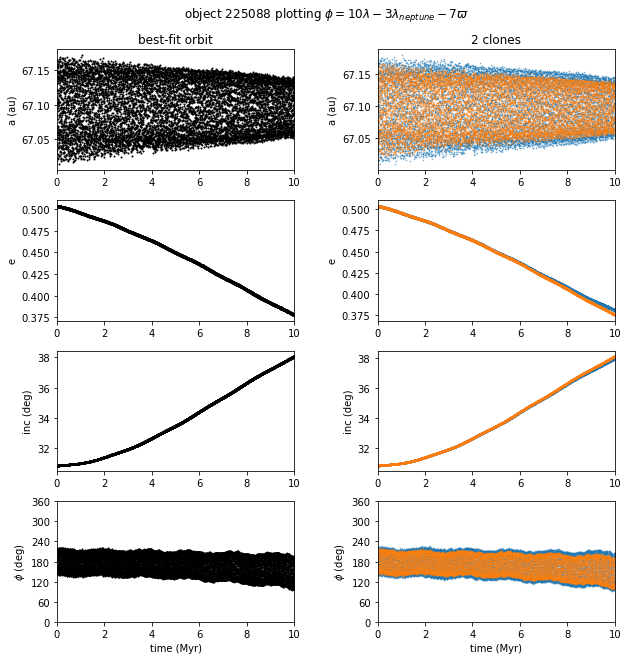

In [8]:
(flag, a, e, inc, node, aperi, ma, phi, t,res_str) = sbd.read_sa_for_resonance(
                            sbody=tno,
                            archivefile=long_simarchive_file,planet='neptune',
                            p=10,q=3,nclones=2)
flag, fig1 = sbd.plot_resonance(
                            sbody=tno,
                            res_string=res_str,
                            a=a,e=e,inc=inc,phi=phi,t=t,nclones=2,
                            figfile='example-resonance-plot.png')